In [1]:
from torch.utils.data import DataLoader
from utils import DatasetFromPath, segment_data
from Dataset import GaitDataset
from LSTMmodel import GaitLSTM
from CNNLSTMmodel import GaitCNNLSTM
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

In [2]:
# Directory of Dataset
data_path = "Dataset"

# Load data
# DataSet contains IMU data, gait speed, and trial that consists of subject and trial information
# Available IMU Locations : Trunk, Thigh, Shank, Foot (Right-Side)
IMU_locations = ['shank', 'foot']
DataSet = DatasetFromPath(data_path, IMU_locations)

print('DataSet.head() : \n', DataSet.head())

DataSet.head() : 
    foot_Accel_X  foot_Accel_Y  foot_Accel_Z  foot_Gyro_X  foot_Gyro_Y  \
0      0.465575      0.071830     -0.008698    -0.132207    -0.002110   
1      0.469012      0.056515     -0.011034    -0.127561    -0.000996   
2      0.465304      0.069267     -0.008440    -0.126917    -0.002110   
3      0.465719      0.066198     -0.012435    -0.128095    -0.002312   
4      0.469377      0.068437     -0.011719    -0.130858    -0.002687   

   foot_Gyro_Z  shank_Accel_X  shank_Accel_Y  shank_Accel_Z  shank_Gyro_X  \
0    -0.039687       0.253425      -0.161833       0.277222     -0.057831   
1    -0.041468       0.250709      -0.165852       0.273380     -0.056401   
2    -0.039496       0.246317      -0.170738       0.266158     -0.052540   
3    -0.038580       0.243900      -0.171735       0.261549     -0.047120   
4    -0.037613       0.243071      -0.170932       0.260261     -0.040978   

   shank_Gyro_Y  shank_Gyro_Z   Speed                 Trial  
0      0.004560  

In [3]:
# Segmenting data
window_size = 200
stride = 30
X, y = segment_data(DataSet, window_size, stride)
print(X.shape)
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create data loaders
train_dataset = GaitDataset(X_train, y_train)
test_dataset = GaitDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


(150523, 200, 12)


In [4]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ML model parameter
input_size = X_train.shape[2]
hidden_size = 256
num_layers = 4
output_size = 1
dropout_prob = 0.4

In [5]:

# Instantiate the model, loss function, and optimizer
# model = GaitLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
model = GaitCNNLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob, bi_directional=True).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


C:\Users\Hurgroup\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 200])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Hurgroup\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 200])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/10, Training Loss: 0.0173
Epoch: 2/10, Training Loss: 0.0087
Epoch: 3/10, Training Loss: 0.0075
Epoch: 4/10, Training Loss: 0.0068
Epoch: 5/10, Training Loss: 0.0063
Epoch: 6/10, Training Loss: 0.0060
Epoch: 7/10, Training Loss: 0.0058
Epoch: 8/10, Training Loss: 0.0057
Epoch: 9/10, Training Loss: 0.0056
Epoch: 10/10, Training Loss: 0.0056


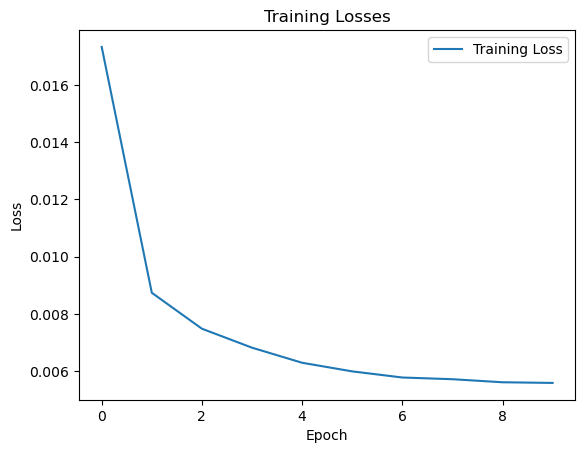

In [6]:

train_losses = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

# Plot train result
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Save the model's state_dict(parameter)
torch.save(model.state_dict(), 'CNNLSTMmodel_2.pth')   

Test Loss: 0.0042
Test accuracy within 0.1 tolerance: 90.35%


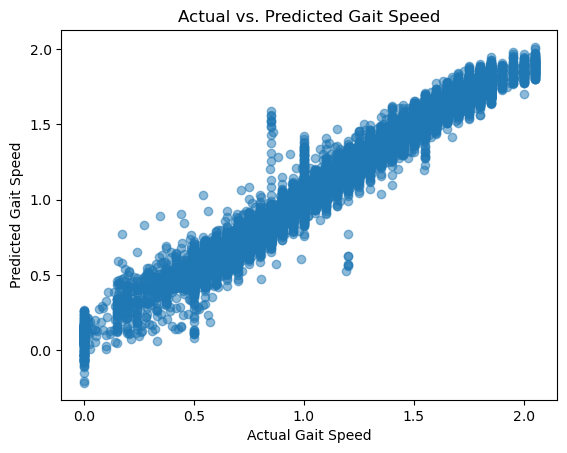

In [7]:

# Initialize the test loss and the total number of correct predictions
test_loss = 0
test_rmse = 0
correct = 0
total = 0
total_samples = 0

actual_speeds = []
predicted_speeds = []

# Iterate through the test dataset
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).float()

        # Forward pass
        outputs = model(inputs)
        
        # Calculate the test loss
        loss = criterion(outputs.view(-1), targets.mean(dim=1))
        test_loss += loss.item()
        
        # Compare the predicted gait speed with the average of the actual gait speeds
        total += targets.size(0)
        correct += torch.isclose(outputs.view(-1), targets.mean(dim=1), atol=0.1).sum().item()
        
        # Store the actual and predicted gait speeds
        actual_speeds.extend(targets.mean(axis=1).view(-1).cpu().numpy())
        predicted_speeds.extend(outputs.view(-1).cpu().numpy())

# Calculate the average test loss
test_loss = test_loss / len(test_loader)

# Calculate the accuracy of the model using a custom tolerance
accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}')
print(f'Test accuracy within 0.1 tolerance: {accuracy:.2f}%')

# Create a scatter plot of actual vs. predicted gait speeds
plt.figure()
plt.scatter(actual_speeds, predicted_speeds, alpha=0.5)
plt.xlabel('Actual Gait Speed')
plt.ylabel('Predicted Gait Speed')
plt.title('Actual vs. Predicted Gait Speed')
plt.show()
